# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [5]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [6]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [8]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [9]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [12]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [15]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [23]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(float)
target_index = np.ones(batch_size, dtype=int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [25]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [26]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.397363
Epoch 1, loss: 2.330354
Epoch 2, loss: 2.311002
Epoch 3, loss: 2.303897
Epoch 4, loss: 2.303257
Epoch 5, loss: 2.302898
Epoch 6, loss: 2.302564
Epoch 7, loss: 2.301815
Epoch 8, loss: 2.301252
Epoch 9, loss: 2.301256


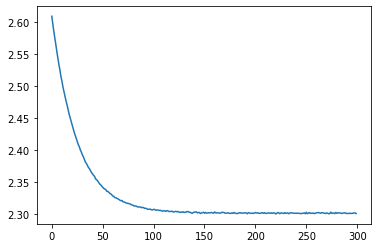

In [27]:
# let's look at the loss history!
plt.plot(loss_history)

In [29]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.127
Epoch 0, loss: 2.301800
Epoch 1, loss: 2.302558
Epoch 2, loss: 2.302208
Epoch 3, loss: 2.303309
Epoch 4, loss: 2.302126
Epoch 5, loss: 2.301524
Epoch 6, loss: 2.301150
Epoch 7, loss: 2.301359
Epoch 8, loss: 2.302305
Epoch 9, loss: 2.302205
Epoch 10, loss: 2.301595
Epoch 11, loss: 2.302039
Epoch 12, loss: 2.301247
Epoch 13, loss: 2.301836
Epoch 14, loss: 2.302396
Epoch 15, loss: 2.302299
Epoch 16, loss: 2.301161
Epoch 17, loss: 2.302058
Epoch 18, loss: 2.302180
Epoch 19, loss: 2.302339
Epoch 20, loss: 2.302694
Epoch 21, loss: 2.301872
Epoch 22, loss: 2.302261
Epoch 23, loss: 2.302209
Epoch 24, loss: 2.302215
Epoch 25, loss: 2.301591
Epoch 26, loss: 2.301535
Epoch 27, loss: 2.302557
Epoch 28, loss: 2.301689
Epoch 29, loss: 2.301815
Epoch 30, loss: 2.301483
Epoch 31, loss: 2.301553
Epoch 32, loss: 2.301640
Epoch 33, loss: 2.301991
Epoch 34, loss: 2.302104
Epoch 35, loss: 2.301741
Epoch 36, loss: 2.302652
Epoch 37, loss: 2.303017
Epoch 38, loss: 2.301521
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [39]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        loss_history = classifier.fit(train_X, train_y, epochs=num_epochs,
                                      learning_rate=lr, batch_size=batch_size, reg=rs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_classifier = classifier
            best_val_accuracy = accuracy
            best_lr, best_rs = lr, rs
            
print('hyper-parameters: lr = {}, rs = {}'.format(lr, rs))
print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.301470
Epoch 1, loss: 2.300368
Epoch 2, loss: 2.299128
Epoch 3, loss: 2.299072
Epoch 4, loss: 2.297444
Epoch 5, loss: 2.295904
Epoch 6, loss: 2.293397
Epoch 7, loss: 2.296875
Epoch 8, loss: 2.295133
Epoch 9, loss: 2.292857
Epoch 10, loss: 2.290978
Epoch 11, loss: 2.291628
Epoch 12, loss: 2.287297
Epoch 13, loss: 2.292894
Epoch 14, loss: 2.289672
Epoch 15, loss: 2.286690
Epoch 16, loss: 2.284671
Epoch 17, loss: 2.287627
Epoch 18, loss: 2.284447
Epoch 19, loss: 2.287718
Epoch 20, loss: 2.285870
Epoch 21, loss: 2.278746
Epoch 22, loss: 2.277522
Epoch 23, loss: 2.284406
Epoch 24, loss: 2.274678
Epoch 25, loss: 2.276643
Epoch 26, loss: 2.281626
Epoch 27, loss: 2.272920
Epoch 28, loss: 2.280301
Epoch 29, loss: 2.277529
Epoch 30, loss: 2.282802
Epoch 31, loss: 2.273901
Epoch 32, loss: 2.271925
Epoch 33, loss: 2.276733
Epoch 34, loss: 2.275226
Epoch 35, loss: 2.284179
Epoch 36, loss: 2.270381
Epoch 37, loss: 2.278204
Epoch 38, loss: 2.266460
Epoch 39, loss: 2.273364
Epoch 40, 

Epoch 124, loss: 2.238724
Epoch 125, loss: 2.239627
Epoch 126, loss: 2.229895
Epoch 127, loss: 2.217815
Epoch 128, loss: 2.219549
Epoch 129, loss: 2.215667
Epoch 130, loss: 2.237329
Epoch 131, loss: 2.197713
Epoch 132, loss: 2.216853
Epoch 133, loss: 2.253070
Epoch 134, loss: 2.219512
Epoch 135, loss: 2.220860
Epoch 136, loss: 2.237236
Epoch 137, loss: 2.220003
Epoch 138, loss: 2.230873
Epoch 139, loss: 2.219746
Epoch 140, loss: 2.249013
Epoch 141, loss: 2.232336
Epoch 142, loss: 2.224393
Epoch 143, loss: 2.201155
Epoch 144, loss: 2.225371
Epoch 145, loss: 2.196251
Epoch 146, loss: 2.229903
Epoch 147, loss: 2.210638
Epoch 148, loss: 2.222474
Epoch 149, loss: 2.215643
Epoch 150, loss: 2.199676
Epoch 151, loss: 2.240989
Epoch 152, loss: 2.233873
Epoch 153, loss: 2.219734
Epoch 154, loss: 2.208523
Epoch 155, loss: 2.191390
Epoch 156, loss: 2.211645
Epoch 157, loss: 2.198004
Epoch 158, loss: 2.206878
Epoch 159, loss: 2.236927
Epoch 160, loss: 2.197007
Epoch 161, loss: 2.228392
Epoch 162, l

Epoch 46, loss: 2.297788
Epoch 47, loss: 2.298475
Epoch 48, loss: 2.295169
Epoch 49, loss: 2.298482
Epoch 50, loss: 2.299064
Epoch 51, loss: 2.297588
Epoch 52, loss: 2.296361
Epoch 53, loss: 2.298292
Epoch 54, loss: 2.295490
Epoch 55, loss: 2.295345
Epoch 56, loss: 2.295824
Epoch 57, loss: 2.295864
Epoch 58, loss: 2.296035
Epoch 59, loss: 2.298090
Epoch 60, loss: 2.296123
Epoch 61, loss: 2.294478
Epoch 62, loss: 2.295385
Epoch 63, loss: 2.295805
Epoch 64, loss: 2.295556
Epoch 65, loss: 2.297864
Epoch 66, loss: 2.299262
Epoch 67, loss: 2.296031
Epoch 68, loss: 2.294514
Epoch 69, loss: 2.293063
Epoch 70, loss: 2.296823
Epoch 71, loss: 2.294473
Epoch 72, loss: 2.296258
Epoch 73, loss: 2.297881
Epoch 74, loss: 2.294027
Epoch 75, loss: 2.294728
Epoch 76, loss: 2.297233
Epoch 77, loss: 2.294478
Epoch 78, loss: 2.296655
Epoch 79, loss: 2.296177
Epoch 80, loss: 2.297156
Epoch 81, loss: 2.296660
Epoch 82, loss: 2.295186
Epoch 83, loss: 2.296778
Epoch 84, loss: 2.296160
Epoch 85, loss: 2.292791


Epoch 168, loss: 2.284896
Epoch 169, loss: 2.284880
Epoch 170, loss: 2.290362
Epoch 171, loss: 2.285224
Epoch 172, loss: 2.283389
Epoch 173, loss: 2.280079
Epoch 174, loss: 2.291716
Epoch 175, loss: 2.285276
Epoch 176, loss: 2.286024
Epoch 177, loss: 2.286556
Epoch 178, loss: 2.291560
Epoch 179, loss: 2.283739
Epoch 180, loss: 2.285296
Epoch 181, loss: 2.286241
Epoch 182, loss: 2.286010
Epoch 183, loss: 2.289867
Epoch 184, loss: 2.291838
Epoch 185, loss: 2.280205
Epoch 186, loss: 2.287064
Epoch 187, loss: 2.292507
Epoch 188, loss: 2.285371
Epoch 189, loss: 2.285890
Epoch 190, loss: 2.286695
Epoch 191, loss: 2.285624
Epoch 192, loss: 2.283705
Epoch 193, loss: 2.288043
Epoch 194, loss: 2.289337
Epoch 195, loss: 2.284346
Epoch 196, loss: 2.281727
Epoch 197, loss: 2.282824
Epoch 198, loss: 2.284262
Epoch 199, loss: 2.287112
Epoch 0, loss: 2.302830
Epoch 1, loss: 2.302059
Epoch 2, loss: 2.302521
Epoch 3, loss: 2.301882
Epoch 4, loss: 2.302166
Epoch 5, loss: 2.302052
Epoch 6, loss: 2.302268


Epoch 92, loss: 2.301129
Epoch 93, loss: 2.301188
Epoch 94, loss: 2.302090
Epoch 95, loss: 2.301103
Epoch 96, loss: 2.301841
Epoch 97, loss: 2.301154
Epoch 98, loss: 2.301282
Epoch 99, loss: 2.301849
Epoch 100, loss: 2.300957
Epoch 101, loss: 2.301581
Epoch 102, loss: 2.301763
Epoch 103, loss: 2.301024
Epoch 104, loss: 2.300356
Epoch 105, loss: 2.301257
Epoch 106, loss: 2.301863
Epoch 107, loss: 2.301597
Epoch 108, loss: 2.301772
Epoch 109, loss: 2.301706
Epoch 110, loss: 2.300723
Epoch 111, loss: 2.301544
Epoch 112, loss: 2.302407
Epoch 113, loss: 2.301370
Epoch 114, loss: 2.301306
Epoch 115, loss: 2.300461
Epoch 116, loss: 2.300986
Epoch 117, loss: 2.301612
Epoch 118, loss: 2.300352
Epoch 119, loss: 2.301434
Epoch 120, loss: 2.301388
Epoch 121, loss: 2.301814
Epoch 122, loss: 2.300148
Epoch 123, loss: 2.301445
Epoch 124, loss: 2.302449
Epoch 125, loss: 2.301346
Epoch 126, loss: 2.300655
Epoch 127, loss: 2.302239
Epoch 128, loss: 2.301181
Epoch 129, loss: 2.300454
Epoch 130, loss: 2.3

Epoch 13, loss: 2.302171
Epoch 14, loss: 2.301418
Epoch 15, loss: 2.303632
Epoch 16, loss: 2.302371
Epoch 17, loss: 2.302759
Epoch 18, loss: 2.302715
Epoch 19, loss: 2.302967
Epoch 20, loss: 2.302050
Epoch 21, loss: 2.301409
Epoch 22, loss: 2.302961
Epoch 23, loss: 2.302788
Epoch 24, loss: 2.301794
Epoch 25, loss: 2.301946
Epoch 26, loss: 2.302082
Epoch 27, loss: 2.302653
Epoch 28, loss: 2.302578
Epoch 29, loss: 2.302353
Epoch 30, loss: 2.301777
Epoch 31, loss: 2.302202
Epoch 32, loss: 2.301120
Epoch 33, loss: 2.302857
Epoch 34, loss: 2.300927
Epoch 35, loss: 2.302072
Epoch 36, loss: 2.301493
Epoch 37, loss: 2.302664
Epoch 38, loss: 2.302251
Epoch 39, loss: 2.302668
Epoch 40, loss: 2.302070
Epoch 41, loss: 2.301394
Epoch 42, loss: 2.302588
Epoch 43, loss: 2.301693
Epoch 44, loss: 2.302451
Epoch 45, loss: 2.301644
Epoch 46, loss: 2.301369
Epoch 47, loss: 2.302212
Epoch 48, loss: 2.302633
Epoch 49, loss: 2.303106
Epoch 50, loss: 2.302405
Epoch 51, loss: 2.302482
Epoch 52, loss: 2.301668


# Какой же точности мы добились на тестовых данных?

In [40]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.195000
